# Sequence classification

It is a predictive modeling problem where you have some sequence of inputs over space or time and the task is to predict a category for the sequence.

*What makes this problem difficult is that the sequences can vary in length, be comprised of a very large vocabulary of input symbols and may require the model to learn the long-term context or dependencies between symbols in the input sequence.*

In this post, you will discover how you can develop LSTM recurrent neural network models for sequence classification problems in Python using the Keras deep learning library.

## Problem Description

The problem that we will use to demonstrate sequence learning in this tutorial is the IMDB movie review sentiment classification problem. Each movie review is a variable sequence of words and the sentiment of each movie review must be classified.

The Large Movie Review Dataset (often referred to as the IMDB dataset) contains 25,000 highly-polar movie reviews (good or bad) for training and the same amount again for testing. The problem is to determine whether a given movie review has a positive or negative sentiment.



Keras provides access to the IMDB dataset built-in. The *imdb.load_data()* function allows you to load the dataset in a format that is ready for use in neural network and deep learning models.

The words have been replaced by integers that indicate the ordered frequency of each word in the dataset. The sentences in each review are therefore comprised of a sequence of integers.

### Word Embedding
1. We will map each movie review into a real vector domain, a popular technique when working with text called word embedding. This is a technique where words are encoded as real-valued vectors in a high dimensional space, where the similarity between words in terms of meaning translates to closeness in the vector space.

Keras provides a convenient way to convert positive integer representations of words into a word embedding by an **Embedding** layer.

2. We will map each word onto a 32 length real valued vector. We will also limit the total number of words that we are interested in modeling to the 5000 most frequent words, and zero out the rest. Finally, the sequence length (number of words) in each review varies, so we will constrain each review to be 500 words, truncating long reviews and pad the shorter reviews with zero values.

Now that we have defined our problem and how the data will be prepared and modeled, we are ready to develop an LSTM model to classify the sentiment of movie reviews.

### Simple LSTM for Sequence Classification
We can quickly develop a small LSTM for the IMDB problem and achieve good accuracy.

Let’s start off by importing the classes and functions required for this model and initializing the random number generator to a constant value to ensure we can easily reproduce the results.

In [6]:
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

We need to load the IMDB dataset. We are constraining the dataset to the top 5,000 words. We also split the dataset into train (50%) and test (50%) sets.

In [ ]:
# Actual code is this.-
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

# But because for some reasons this couldn't be loaded, we use the code below as a trick to load the same dataset

In [8]:
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# restore np.load for future normal usage
np.load = np_load_old

Next, we need to truncate and pad the input sequences so that they are all the same length for modeling. The model will learn the zero values carry no information so indeed the sequences are not the same length in terms of content, but same length vectors is required to perform the computation in Keras.

In [9]:
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

# LSTM

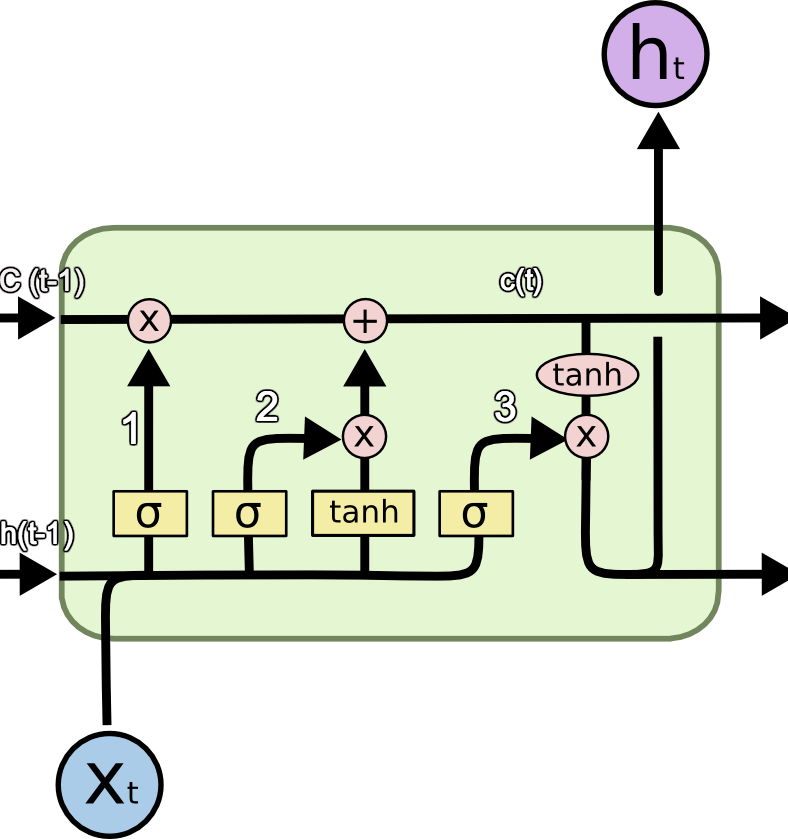

The **Long Short-Term Memory network, or LSTM network**, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.

As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

* Instead of neurons, LSTM networks have memory blocks that are connected through layers.

* A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

1. Forget Gate: conditionally decides what information to throw away from the block.
2. Input Gate: conditionally decides which values from the input to update the memory state.
3. Output Gate: conditionally decides what to output based on input and the memory of the block.

Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.

You can see how you may achieve sophisticated learning and memory from a layer of LSTMs, and it is not hard to imagine how higher-order abstractions may be layered with multiple such layers.

## Model -

We can now define, compile and fit our LSTM model.

* The first layer is the Embedded layer that uses 32 length vectors to represent each word. The next layer is the LSTM layer with 100 memory units (smart neurons).

* Finally, because this is a classification problem we use a Dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 predictions for the two classes (good and bad) in the problem.

* Because it is a binary classification problem, log loss is used as the loss function (*binary_crossentropy* in Keras). The efficient ADAM optimization algorithm is used. The model is fit for only 2 epochs because it quickly overfits the problem. A large batch size of 64 reviews is used to space out weight updates.

In [10]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
# Embedding converts positive integers to a vector of fixed size (given by 2nd arg)
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 182s 7ms/step - loss: 0.4365 - acc: 0.7937 - val_loss: 0.3252 - val_acc: 0.8651
Epoch 2/3
25000/25000 [==============================] - 188s 8ms/step - loss: 0.3642 - acc: 0.8405 - val_loss: 0.5864 - val_acc: 0.6738
Epoch 3/3
25000/25000 [==============================] - 181s 7ms/step 

## Testing the model
Once fit, we estimate the performance of the model on unseen reviews

In [11]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 86.25%


### LSTM For Sequence Classification With Dropout
Recurrent Neural networks like LSTM generally have the problem of overfitting.

Dropout can be applied between layers using the Dropout Keras layer. We can do this easily by adding new Dropout layers between the Embedding and LSTM layers and the LSTM and Dense output layers. For example:





In [ ]:
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# 1-D Convolutions

Many articles focus on two dimensional convolutional neural networks. They are particularly used for image recognition problems. 1D CNNs are covered to some extend, e.g. for natural language processing (NLP).

* 1D convolutional neural nets can be used for extracting local 1D patches (subsequences) from sequences and can identify local patterns within the window of convolution. 

* A CNN works well for identifying simple patterns within your data which will then be used to form more complex patterns within higher layers. A 1D CNN is very effective when you expect to derive interesting features from shorter (fixed-length) segments of the overall data set and where the location of the feature within the segment is not of high relevance.

This applies well to the analysis of time sequences of sensor data (such as gyroscope or accelerometer data). It also applies to the analysis of any kind of signal data over a fixed-length period (such as audio signals). Another application is NLP (although here LSTM networks are more promising since the proximity of words might not always be a good indicator for a trainable pattern).


## Difference between 1D,2D,3D Convolutions -

* CNNs share the same characteristics and follow the same approach, no matter if it is 1D, 2D or 3D. The key difference is the dimensionality of the input data and how the feature detector (or filter) slides across the data
* The number of dimensions is a property of the problem being solved. For example, 1D for audio signals, 2D for images, 3D for movies . . .

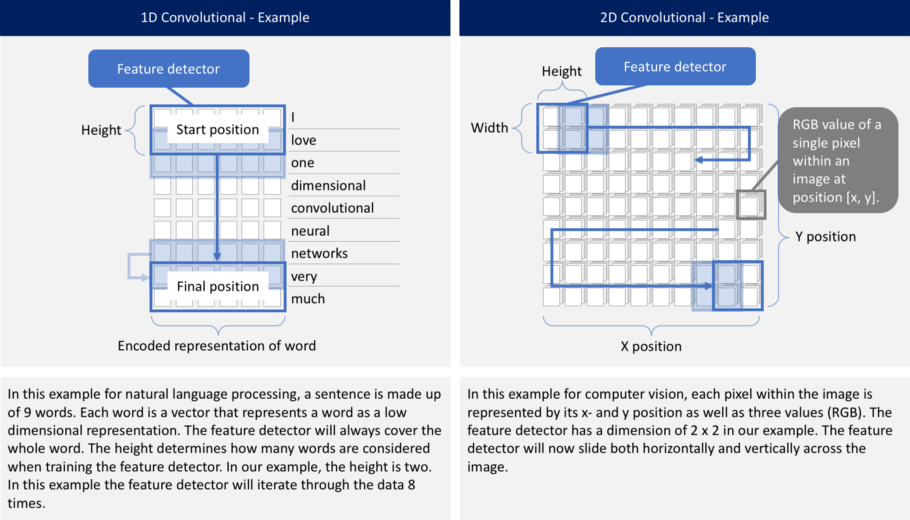

## LSTM and Convolutional Neural Network For Sequence Classification

Convolutional neural networks excel at learning the spatial structure in input data.

* The IMDB review data does have a one-dimensional spatial structure in the sequence of words in reviews and the CNN may be able to pick out invariant features for good and bad sentiment. This learned spatial features may then be learned as sequences by an LSTM layer.

* We can easily add a one-dimensional CNN and max pooling layers after the Embedding layer which then feed the consolidated features to the LSTM. We can use a smallish set of 32 features with a small filter length of 3. The pooling layer can use the standard length of 2 to halve the feature map size.

The full code listing with a CNN and LSTM layers is listed below for completeness

In [ ]:
# LSTM and CNN for sequence classification in the IMDB dataset

import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

We can see that we achieve similar results to the first example although with less weights and faster training time.

I would expect that even better results could be achieved if this example was further extended to use dropout.